### importing dependencies

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from model_utility import plot_images
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
import pydot

In [2]:
tf.__version__

'2.10.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices


[]

### Constants

In [4]:
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

#### data

In [5]:
dataset_dir = "../../dataset"
train_dir =  os.path.join(dataset_dir, "train")
val_dir =  os.path.join(dataset_dir, "val")
test_dir =  os.path.join(dataset_dir + "/test", "test")

#### Model

In [6]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

#### Training

In [7]:
EPOCHS = 10
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

### Load data

In [8]:
def count_images_and_classes(directory):
    # Get a list of subdirectories in the directory, each representing a class
    class_names = os.listdir(directory)

    # Initialize a dictionary to store the count of images in each class
    class_counts = {}

    # Iterate over each class directory and count the number of images
    total_images = 0  # Initialize a variable to store the total number of images

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files (images) in the class directory
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images  # Increment the total number of images

    return class_counts, len(class_names), total_images

# Count and print the statistics for the training data
train_class_counts, train_total_classes, train_total_images = count_images_and_classes(train_dir)
# Count and print the statistics for the validation data
val_class_counts, val_total_classes, val_total_images = count_images_and_classes(val_dir)
# Count and print the statistics for the test data
test_class_counts, test_total_classes, test_total_images = count_images_and_classes(test_dir)

In [9]:
# Print the statistics for each dataset
print("Training Data:")
for class_name, num_images in train_class_counts.items():
    print(f"{class_name}: {num_images} images")
print(f"\nTotal training classes: {train_total_classes}")
print(f"Total training images: {train_total_images}")

print("\nValidation Data:")
for class_name, num_images in val_class_counts.items():
    print(f"{class_name}: {num_images} images")
print(f"\nTotal validation classes: {val_total_classes}")
print(f"Total validation images: {val_total_images}")

Training Data:
Apple___Apple_scab: 2016 images
Apple___Black_rot: 1987 images
Apple___Cedar_apple_rust: 1760 images
Apple___healthy: 2008 images
Blueberry___healthy: 1816 images
Cherry_(including_sour)___healthy: 1826 images
Cherry_(including_sour)___Powdery_mildew: 1683 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
Corn_(maize)___Common_rust_: 1907 images
Corn_(maize)___healthy: 1859 images
Corn_(maize)___Northern_Leaf_Blight: 1908 images
Grape___Black_rot: 1888 images
Grape___Esca_(Black_Measles): 1920 images
Grape___healthy: 1692 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 images
Orange___Haunglongbing_(Citrus_greening): 2010 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 1728 images
Pepper,_bell___Bacterial_spot: 1913 images
Pepper,_bell___healthy: 1988 images
Potato___Early_blight: 1939 images
Potato___healthy: 1824 images
Potato___Late_blight: 1939 images
Raspberry___healthy: 1781 images
Soybean___healthy: 2022 images
Squash___Pow

In [10]:
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(test_dir):
    img = load_img(os.path.join(test_dir, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)
    print(img_name)
    
test_image_data = np.array(test_image_data)/255
print(f'\nTotal testing images: {len(test_image_data)}')

AppleCedarRust1.JPG
AppleCedarRust2.JPG
AppleCedarRust3.JPG
AppleCedarRust4.JPG
AppleScab1.JPG
AppleScab2.JPG
AppleScab3.JPG
CornCommonRust1.JPG
CornCommonRust2.JPG
CornCommonRust3.JPG
PotatoEarlyBlight1.JPG
PotatoEarlyBlight2.JPG
PotatoEarlyBlight3.JPG
PotatoEarlyBlight4.JPG
PotatoEarlyBlight5.JPG
PotatoHealthy1.JPG
PotatoHealthy2.JPG
TomatoEarlyBlight1.JPG
TomatoEarlyBlight2.JPG
TomatoEarlyBlight3.JPG
TomatoEarlyBlight4.JPG
TomatoEarlyBlight5.JPG
TomatoEarlyBlight6.JPG
TomatoHealthy1.JPG
TomatoHealthy2.JPG
TomatoHealthy3.JPG
TomatoHealthy4.JPG
TomatoYellowCurlVirus1.JPG
TomatoYellowCurlVirus2.JPG
TomatoYellowCurlVirus3.JPG
TomatoYellowCurlVirus4.JPG
TomatoYellowCurlVirus5.JPG
TomatoYellowCurlVirus6.JPG

Total testing images: 33


### Image Generators

#### Train

In [11]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = train_dir,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 70295 images belonging to 38 classes.


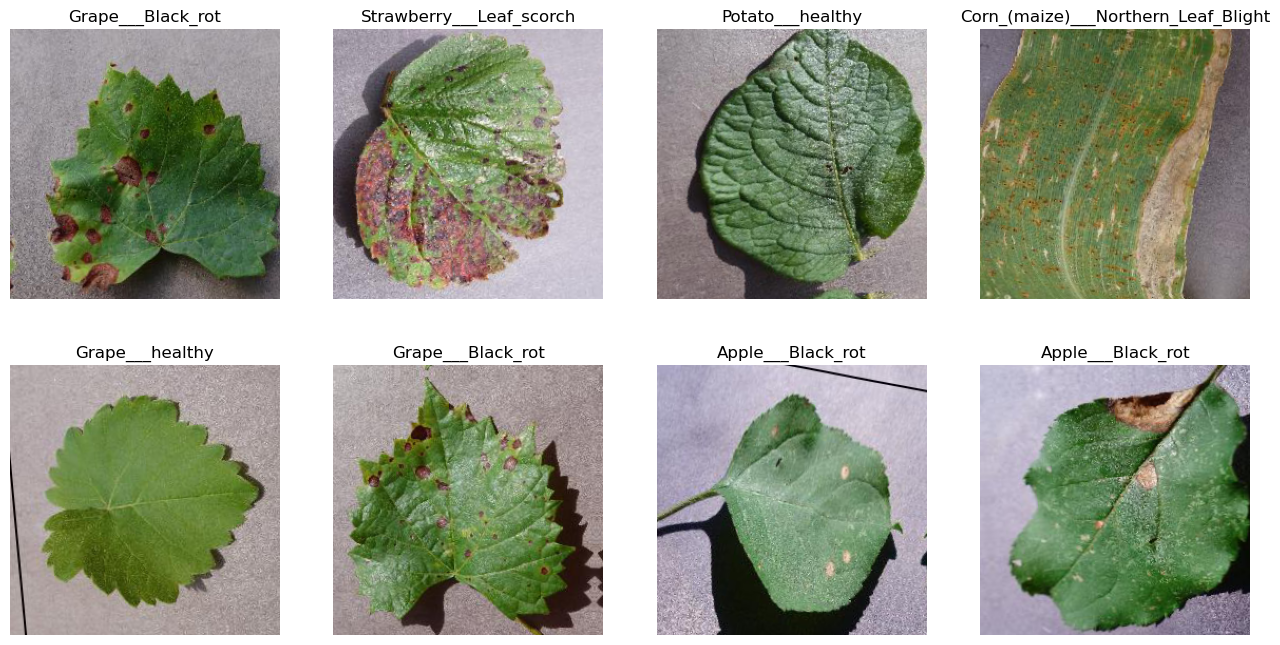

In [12]:
plot_images(train_data_gen)

### Validation

In [13]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = val_dir,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


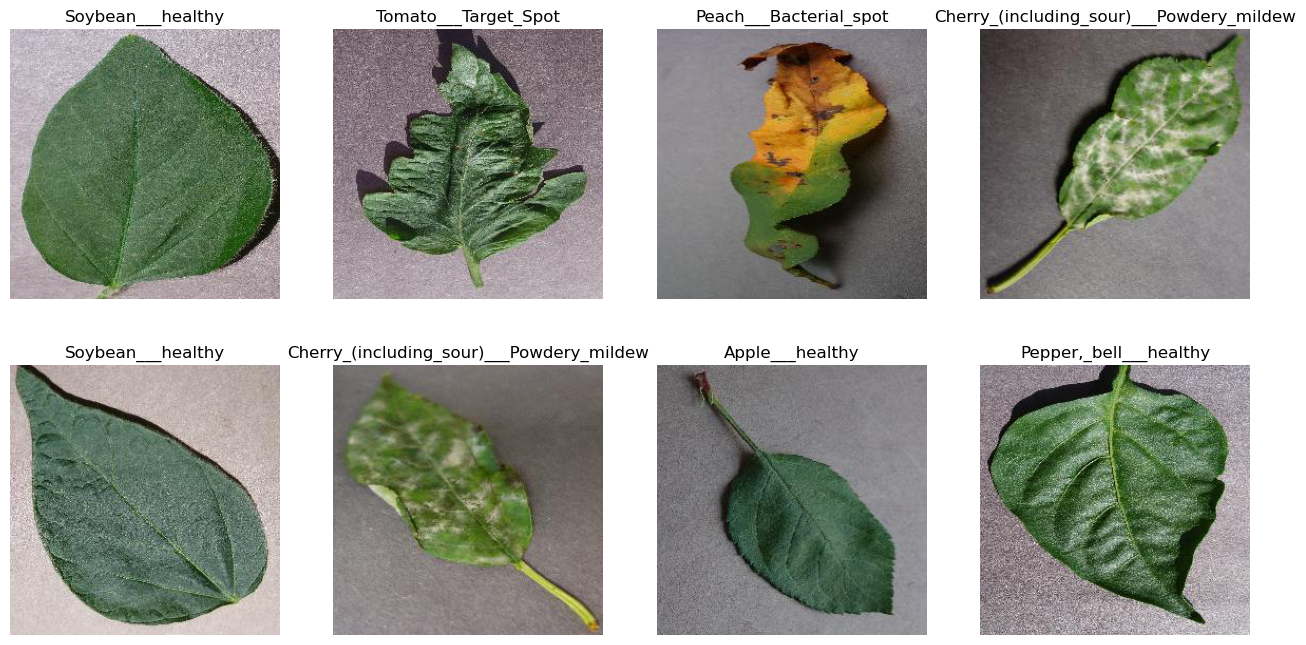

In [14]:
plot_images(val_data_gen)

In [15]:
total_classes = len(os.listdir(train_dir))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


In [16]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}
for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Blueberry___healthy
 5 : Cherry_(including_sour)___Powdery_mildew
 6 : Cherry_(including_sour)___healthy
 7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 8 : Corn_(maize)___Common_rust_
 9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_blight
31 : Tomato___Leaf_Mold
32 : Tomato___Septoria_leaf_spot
33 

### Model

#### Input Layer

In [17]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

TensorShape([None, 256, 256, 3])

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [18]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

TensorShape([None, 256, 256, 24])

In [19]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

TensorShape([None, 256, 256, 32])

In [20]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

TensorShape([None, 128, 128, 32])

#### Block 2

In [21]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

TensorShape([None, 128, 128, 32])

In [22]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

TensorShape([None, 128, 128, 64])

In [23]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

TensorShape([None, 64, 64, 64])

#### Block 3

In [24]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

TensorShape([None, 64, 64, 64])

In [25]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

TensorShape([None, 64, 64, 128])

In [26]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

TensorShape([None, 32, 32, 128])

#### Block 4

In [27]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

TensorShape([None, 32, 32, 128])

In [28]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

TensorShape([None, 32, 32, 256])

In [29]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

TensorShape([None, 16, 16, 256])

#### Block 5

In [30]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

TensorShape([None, 16, 16, 256])

In [31]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

TensorShape([None, 16, 16, 512])

In [32]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

TensorShape([None, 8, 8, 512])

### Global Average Pooling layers for each block

In [33]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

TensorShape([None, 32])

In [34]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

TensorShape([None, 64])

In [35]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

TensorShape([None, 128])

In [36]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

TensorShape([None, 256])

In [37]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

TensorShape([None, 512])

### Concatenation Layer

In [38]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

TensorShape([None, 992])

### Dropout and Dense Layers

In [39]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

TensorShape([None, 992])

In [40]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

TensorShape([None, 512])

In [41]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

TensorShape([None, 512])

In [42]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

TensorShape([None, 38])

### Model Summary

In [43]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "Plant_Leaf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 DwC_1 (DepthwiseConv2D)        (None, 256, 256, 24  120         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 PwC_1 (Conv2D)                 (None, 256, 256, 32  800         ['DwC_1[0][0]']                  
                                )                                                        

### Training

### Callbacks

In [44]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

### History 

In [45]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/10
1099/1099 [==============================] - 4274s 4s/step - loss: 2.3952 - accuracy: 0.3202 - val_loss: 1.6998 - val_accuracy: 0.4958
Epoch 2/10
1099/1099 [==============================] - 4337s 4s/step - loss: 0.9230 - accuracy: 0.7072 - val_loss: 0.9860 - val_accuracy: 0.7015
Epoch 3/10
1099/1099 [==============================] - 4106s 4s/step - loss: 0.5386 - accuracy: 0.8250 - val_loss: 0.7504 - val_accuracy: 0.7799
Epoch 4/10
1099/1099 [==============================] - 4093s 4s/step - loss: 0.3906 - accuracy: 0.8721 - val_loss: 0.5811 - val_accuracy: 0.8241
Epoch 5/10
1099/1099 [==============================] - 4066s 4s/step - loss: 0.3143 - accuracy: 0.8968 - val_loss: 0.3515 - val_accuracy: 0.8863
Epoch 6/10
1099/1099 [==============================] - 4087s 4s/step - loss: 0.2558 - accuracy: 0.9156 - val_loss: 0.5280 - val_accuracy: 0.8511
Epoch 7/10
1099/1099 [==============================] - 4056s 4s/step - loss: 0.2284 - accuracy: 0.9242 - val_loss: 0.3808 -

In [46]:
model.save('models/plant_leaf_disease')

INFO:tensorflow:Assets written to: models/plant_leaf_disease_detector\assets


INFO:tensorflow:Assets written to: models/plant_leaf_disease_detector\assets


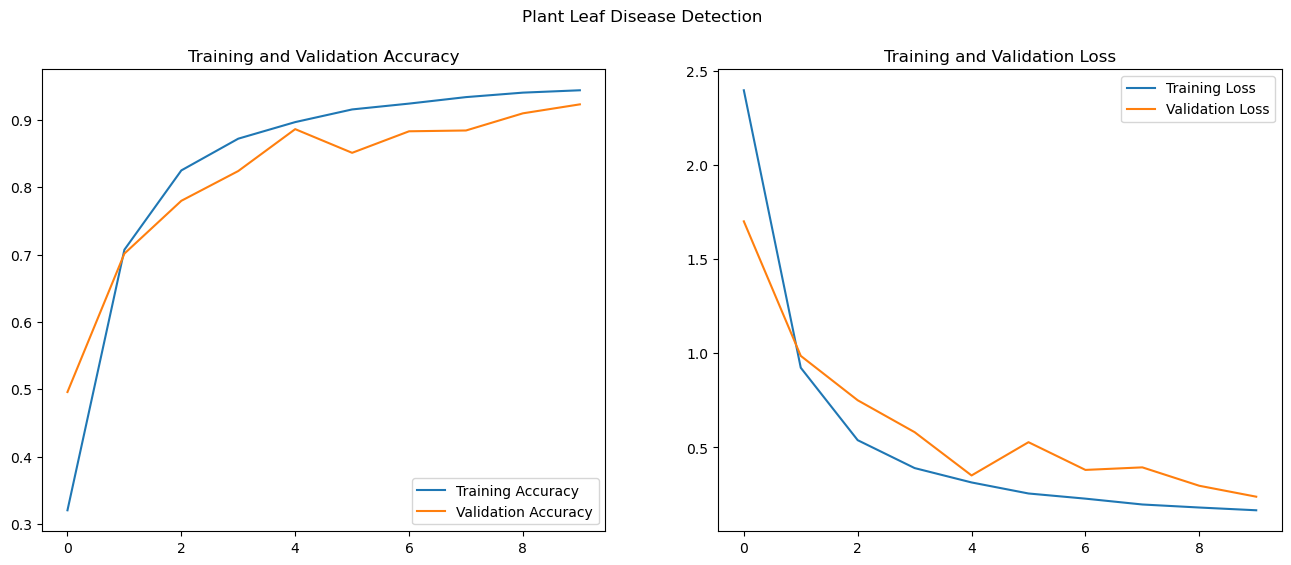

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Plant Leaf Disease Detection')

plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

### Evaluation

In [49]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)
test_pred

2/2 [==============================] - 1s 25ms/step


array([ 2,  2,  2,  2,  5,  0,  0,  8,  8,  8, 20, 20, 20, 20, 20, 22, 22,
       29, 29, 29, 29, 29, 29, 37, 37, 37, 37, 35, 35, 35, 35, 35, 35],
      dtype=int64)

In [50]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

Filename                         Predicted classes
0          AppleCedarRust1.JPG                  Apple___Cedar_apple_rust
1          AppleCedarRust2.JPG                  Apple___Cedar_apple_rust
2          AppleCedarRust3.JPG                  Apple___Cedar_apple_rust
3          AppleCedarRust4.JPG                  Apple___Cedar_apple_rust
4               AppleScab1.JPG  Cherry_(including_sour)___Powdery_mildew
5               AppleScab2.JPG                        Apple___Apple_scab
6               AppleScab3.JPG                        Apple___Apple_scab
7          CornCommonRust1.JPG               Corn_(maize)___Common_rust_
8          CornCommonRust2.JPG               Corn_(maize)___Common_rust_
9          CornCommonRust3.JPG               Corn_(maize)___Common_rust_
10      PotatoEarlyBlight1.JPG                     Potato___Early_blight
11      PotatoEarlyBlight2.JPG                     Potato___Early_blight
12      PotatoEarlyBlight3.JPG                     Potato___Early_blight
13      PotatoEarlyBlight4.JPG                     Potato___Early_blight
14      PotatoEarlyBlight5.JPG                     Potato___Early_blight
15          PotatoHealthy1.JPG                          Potato___healthy
16          PotatoHealthy2.JPG                          Potato___healthy
17      TomatoEarlyBlight1.JPG                     Tomato___Early_blight
18      TomatoEarlyBlight2.JPG                     Tomato___Early_blight
19      TomatoEarlyBlight3.JPG                     Tomato___Early_blight
20      TomatoEarlyBlight4.JPG                     Tomato___Early_blight
21      TomatoEarlyBlight5.JPG                     Tomato___Early_blight
22      TomatoEarlyBlight6.JPG                     Tomato___Early_blight
23          TomatoHealthy1.JPG                          Tomato___healthy
24          TomatoHealthy2.JPG                          Tomato___healthy
25          TomatoHealthy3.JPG                          Tomato___healthy
26          TomatoHealthy4.JPG                          Tomato___healthy
27  TomatoYellowCurlVirus1.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus
28  TomatoYellowCurlVirus2.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus
29  TomatoYellowCurlVirus3.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus
30  TomatoYellowCurlVirus4.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus
31  TomatoYellowCurlVirus5.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus
32  TomatoYellowCurlVirus6.JPG    Tomato___Tomato_Yellow_Leaf_Curl_Virus

### Visualizing test data predictions

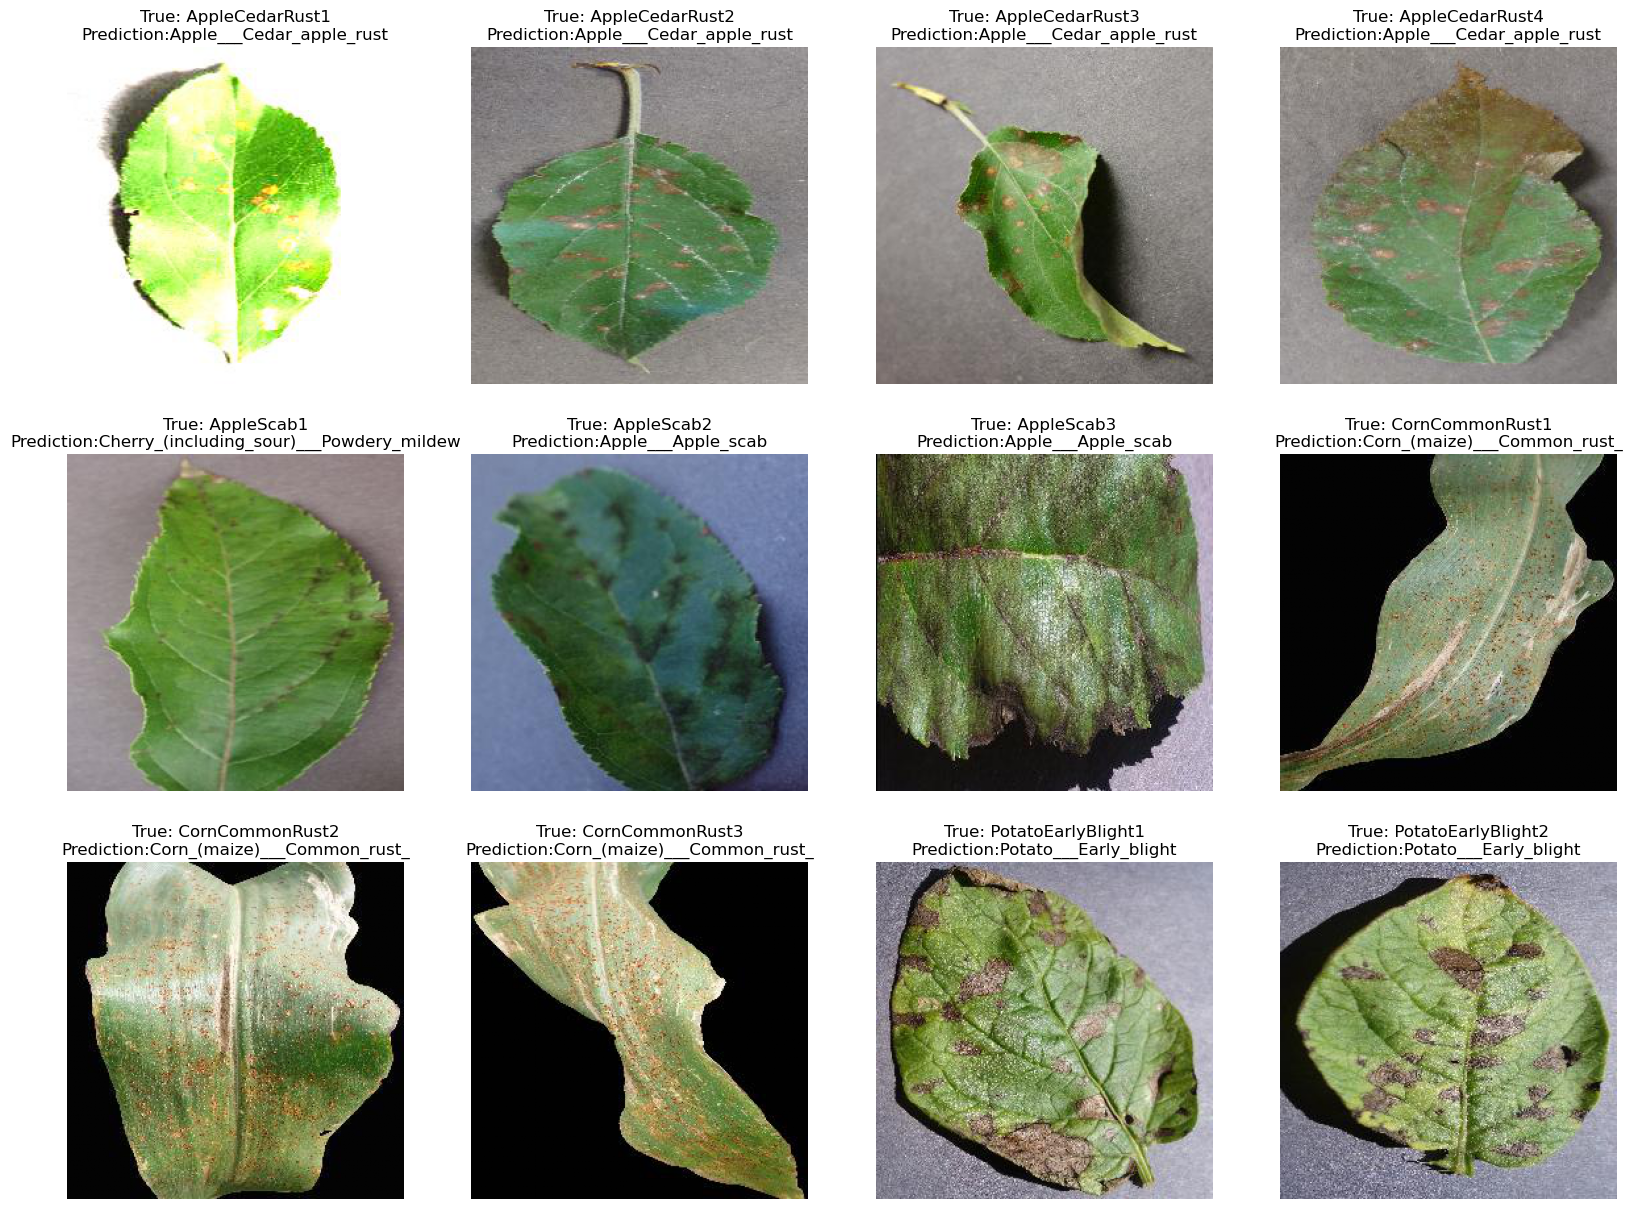

In [51]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")

plt.show()

#### Confusion matrix for validation data

In [52]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = val_dir,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


275/275 [==============================] - 255s 925ms/step


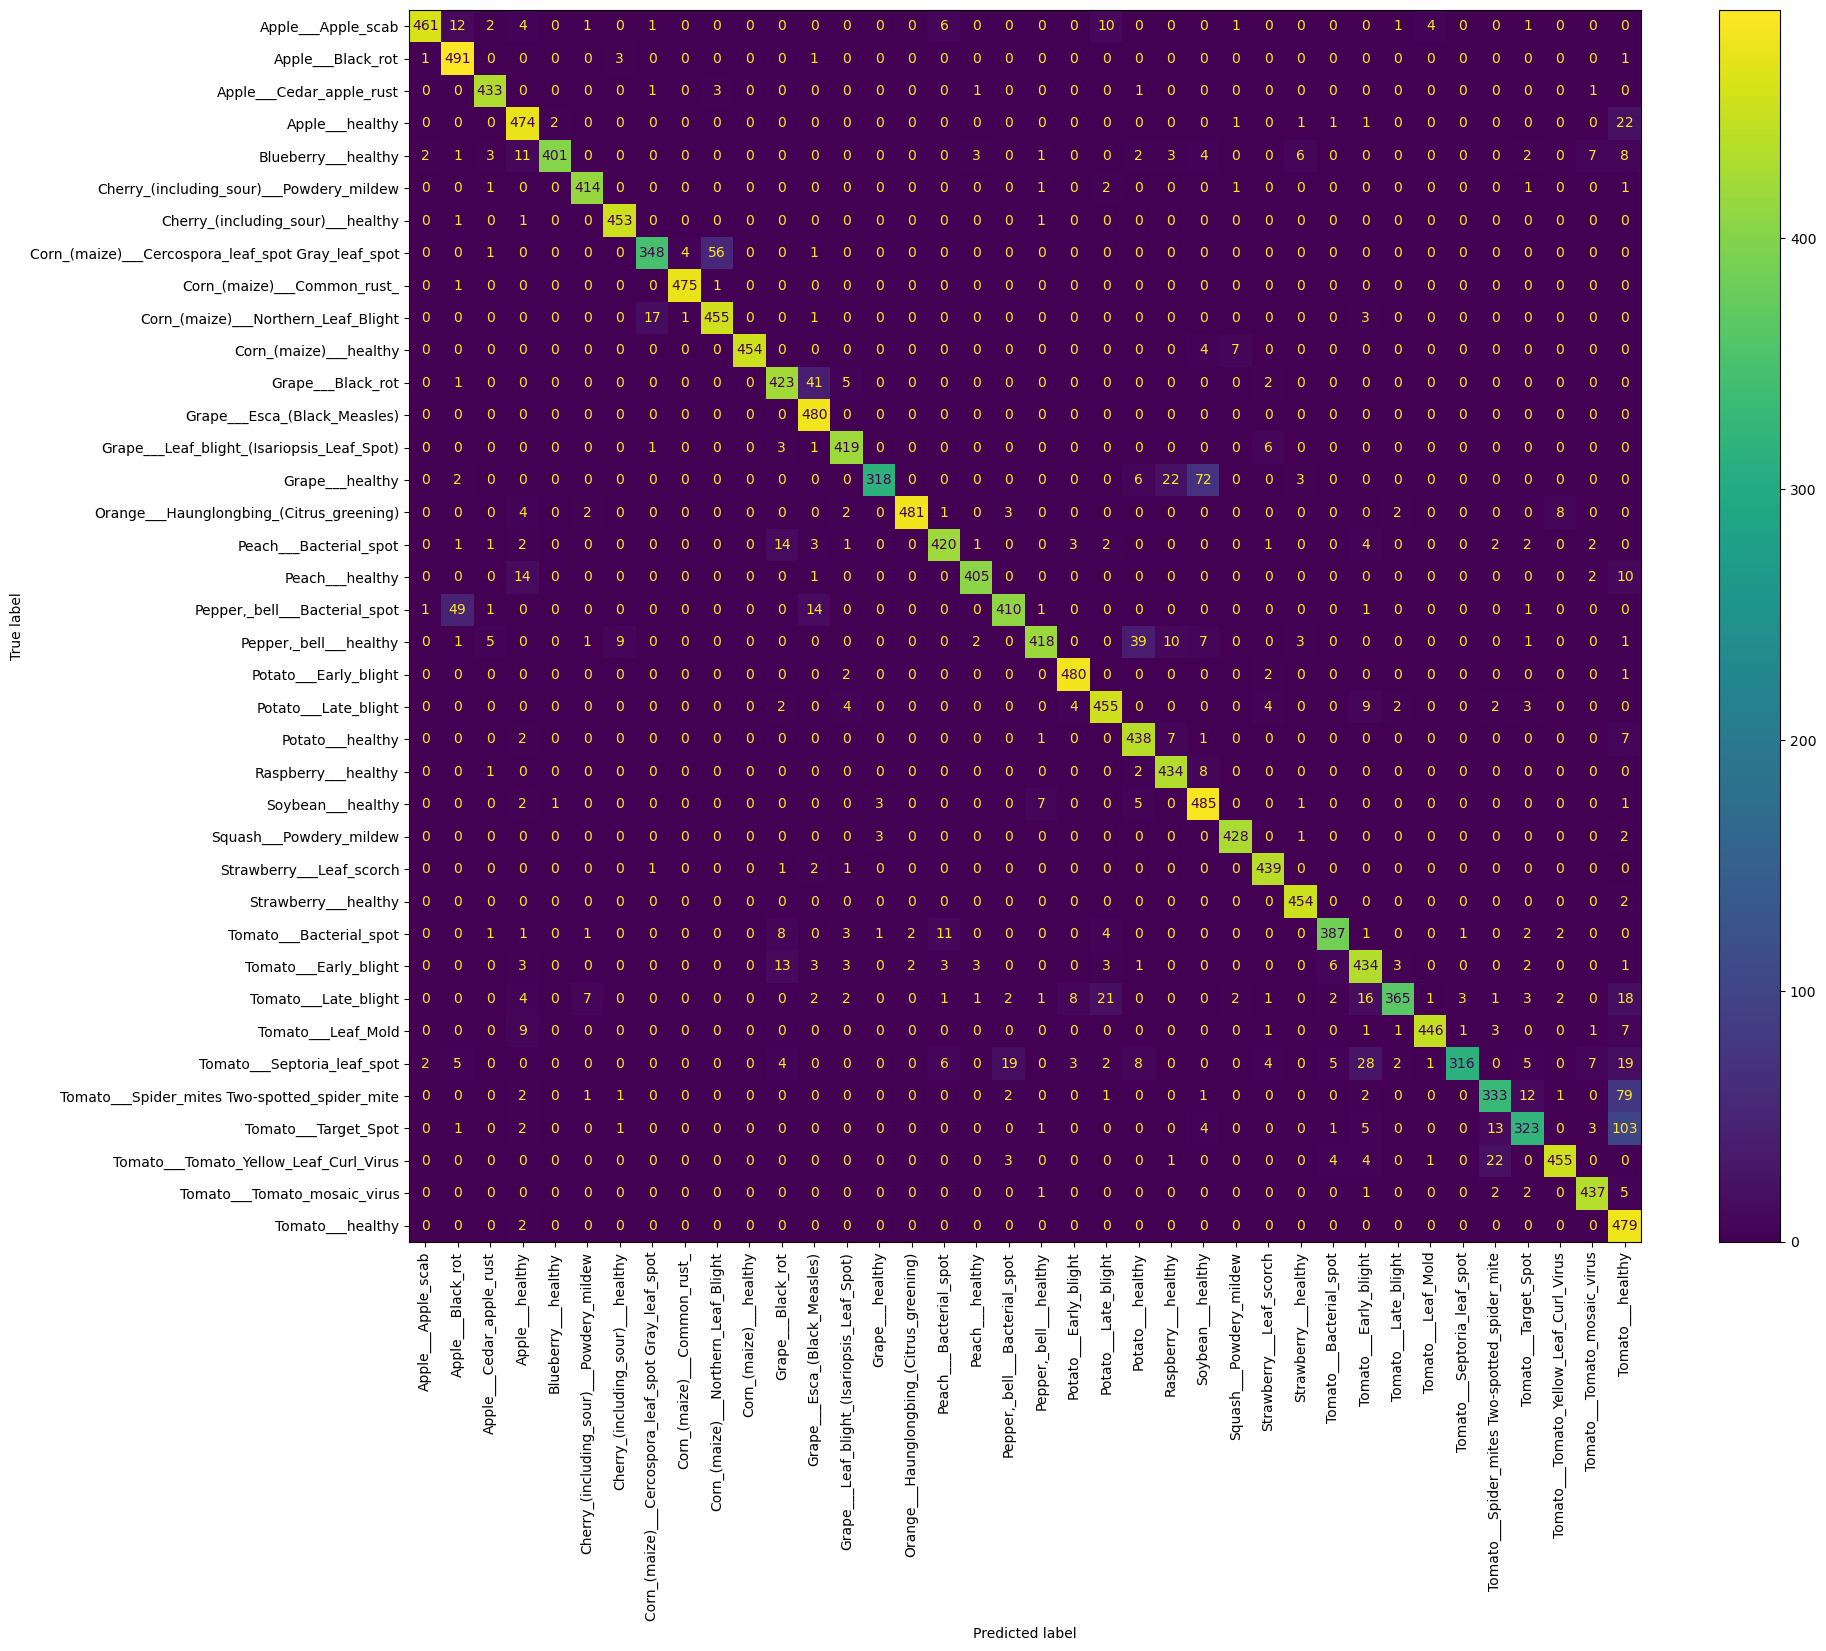

In [53]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

### Saving the model

In [55]:
model.save('models/plant_disease_detector')

INFO:tensorflow:Assets written to: models/plant_disease_detector\assets


INFO:tensorflow:Assets written to: models/plant_disease_detector\assets
